# 26e: Voids Are Directional

**Claim**: Folk wisdom says "Voids help offense, hurt defense"

**Null Hypothesis**: Voids affect outcomes symmetrically

**Method**:
Since P0 is always declarer (offense) in our data, we test:
1. Team voids (P0 + P2) should correlate positively with E[V]
2. Opponent voids (P1 + P3) should correlate negatively with E[V]
3. The difference (team_voids - opp_voids) should show strong positive correlation

**Confirmed If**: Team voids help E[V], opponent voids hurt E[V]

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Define Void Counting Functions

In [2]:
def domino_suits(d_id: int) -> set:
    """Return set of suits this domino belongs to."""
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:
        return {pips[0]}  # Doubles belong to one suit
    return {pips[0], pips[1]}

def count_voids(hand: list, trump_suit: int = None) -> int:
    """Count number of void suits in a hand.
    
    trump_suit: If specified (0-6), exclude from void count.
                If 7+ (no-trump/special), consider all suits.
    """
    # Track which suits are present
    suits_present = set()
    for d in hand:
        suits_present.update(domino_suits(d))
    
    # Count voids (suits 0-6)
    n_voids = 0
    for suit in range(7):
        if trump_suit is not None and suit == trump_suit and trump_suit < 7:
            continue  # Skip trump suit
        if suit not in suits_present:
            n_voids += 1
    
    return n_voids

# Test
test_hand = [0, 1, 2, 3, 4, 5, 6]  # 0-0, 1-0, 1-1, 2-0, 2-1, 2-2, 3-0
print(f"Test hand: {[f'{schema.domino_pips(d)}' for d in test_hand]}")
print(f"Suits present: 0, 1, 2, 3")
print(f"Voids (no trump): {count_voids(test_hand)}")
print(f"Voids (trump=0): {count_voids(test_hand, trump_suit=0)}")

Test hand: ['(0, 0)', '(1, 0)', '(1, 1)', '(2, 0)', '(2, 1)', '(2, 2)', '(3, 0)']
Suits present: 0, 1, 2, 3
Voids (no trump): 3
Voids (trump=0): 3


## 2. Load Data and Compute Team/Opponent Voids

In [3]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands")
print(f"E[V] range: [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")

Loaded 200 hands
E[V] range: [-29.3, 42.0]


In [4]:
# Compute voids for all players in each hand
void_data = []

for _, row in df.iterrows():
    seed = int(row['base_seed'])
    trump = int(row['trump_suit'])
    
    hands = deal_from_seed(seed)
    
    # Count voids for each player
    voids_p0 = count_voids(hands[0], trump_suit=trump)
    voids_p1 = count_voids(hands[1], trump_suit=trump)
    voids_p2 = count_voids(hands[2], trump_suit=trump)
    voids_p3 = count_voids(hands[3], trump_suit=trump)
    
    # Team voids (P0 + P2 = Team 0)
    team_voids = voids_p0 + voids_p2
    opp_voids = voids_p1 + voids_p3
    
    void_data.append({
        'base_seed': seed,
        'voids_p0': voids_p0,
        'voids_p1': voids_p1,
        'voids_p2': voids_p2,
        'voids_p3': voids_p3,
        'team_voids': team_voids,
        'opp_voids': opp_voids,
        'void_advantage': team_voids - opp_voids,
    })

void_df = pd.DataFrame(void_data)

# Merge with main features
df = df.merge(void_df, on='base_seed')

print(f"Team voids distribution:")
print(df['team_voids'].value_counts().sort_index())
print(f"\nOpponent voids distribution:")
print(df['opp_voids'].value_counts().sort_index())

Team voids distribution:
team_voids
0    52
1    82
2    55
3     8
4     3
Name: count, dtype: int64

Opponent voids distribution:
opp_voids
0    48
1    72
2    61
3    18
4     1
Name: count, dtype: int64


## 3. Statistical Analysis

In [5]:
# Bivariate correlations with E[V]
r_team, p_team = stats.pearsonr(df['team_voids'], df['V_mean'])
r_opp, p_opp = stats.pearsonr(df['opp_voids'], df['V_mean'])
r_adv, p_adv = stats.pearsonr(df['void_advantage'], df['V_mean'])
r_p0, p_p0 = stats.pearsonr(df['voids_p0'], df['V_mean'])

print("BIVARIATE CORRELATIONS: Voids vs E[V]")
print("="*55)
print(f"P0 voids vs E[V]:           r = {r_p0:+.4f}, p = {p_p0:.4f}")
print(f"Team voids vs E[V]:         r = {r_team:+.4f}, p = {p_team:.4f}")
print(f"Opponent voids vs E[V]:     r = {r_opp:+.4f}, p = {p_opp:.4f}")
print(f"Void advantage vs E[V]:     r = {r_adv:+.4f}, p = {p_adv:.4f}")

# Directional check
print("\nDIRECTIONAL CHECK:")
print(f"  Team voids help E[V]?        {r_team > 0 and p_team < 0.05}")
print(f"  Opponent voids hurt E[V]?    {r_opp < 0 and p_opp < 0.05}")

BIVARIATE CORRELATIONS: Voids vs E[V]
P0 voids vs E[V]:           r = +0.2270, p = 0.0012
Team voids vs E[V]:         r = +0.0938, p = 0.1864
Opponent voids vs E[V]:     r = -0.1172, p = 0.0983
Void advantage vs E[V]:     r = +0.1490, p = 0.0352

DIRECTIONAL CHECK:
  Team voids help E[V]?        False
  Opponent voids hurt E[V]?    False


In [6]:
# Also check correlation with σ(V)
r_team_sig, p_team_sig = stats.pearsonr(df['team_voids'], df['V_std'])
r_opp_sig, p_opp_sig = stats.pearsonr(df['opp_voids'], df['V_std'])

print("\nBONUS: Voids vs σ(V)")
print("="*55)
print(f"Team voids vs σ(V):         r = {r_team_sig:+.4f}, p = {p_team_sig:.4f}")
print(f"Opponent voids vs σ(V):     r = {r_opp_sig:+.4f}, p = {p_opp_sig:.4f}")


BONUS: Voids vs σ(V)
Team voids vs σ(V):         r = -0.0890, p = 0.2100
Opponent voids vs σ(V):     r = -0.0192, p = 0.7878


In [7]:
# Multivariate regression: E[V] ~ team_voids + opp_voids + controls
X = df[['team_voids', 'opp_voids', 'n_doubles', 'trump_count']]
X = sm.add_constant(X)
y = df['V_mean']

model = sm.OLS(y, X).fit()

print("\nMULTIVARIATE REGRESSION: E[V] ~ team_voids + opp_voids + controls")
print("="*65)
print(model.summary().tables[1])


MULTIVARIATE REGRESSION: E[V] ~ team_voids + opp_voids + controls
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.8687      3.291     -1.175      0.241     -10.359       2.622
team_voids      1.3683      1.152      1.188      0.236      -0.904       3.641
opp_voids      -0.7612      1.119     -0.681      0.497      -2.967       1.445
n_doubles       7.1409      1.078      6.624      0.000       5.015       9.267
trump_count     3.6319      0.842      4.311      0.000       1.970       5.293


In [8]:
# Extract key coefficients
coef_team = model.params['team_voids']
pval_team = model.pvalues['team_voids']
ci_team = model.conf_int().loc['team_voids']

coef_opp = model.params['opp_voids']
pval_opp = model.pvalues['opp_voids']
ci_opp = model.conf_int().loc['opp_voids']

print("\nKEY RESULTS: Void coefficients (multivariate)")
print("="*55)
print(f"Team voids:     coef = {coef_team:+.3f}, 95% CI = [{ci_team[0]:.3f}, {ci_team[1]:.3f}], p = {pval_team:.4f}")
print(f"Opponent voids: coef = {coef_opp:+.3f}, 95% CI = [{ci_opp[0]:.3f}, {ci_opp[1]:.3f}], p = {pval_opp:.4f}")

# Confirmation check: team voids should be positive, opp voids should be negative
team_confirmed = (pval_team < 0.05 and coef_team > 0)
opp_confirmed = (pval_opp < 0.05 and coef_opp < 0)
directional_confirmed = team_confirmed and opp_confirmed

print("\nCONFIRMATION STATUS:")
print(f"  Team voids help (coef > 0, p < 0.05)?     {team_confirmed}")
print(f"  Opp voids hurt (coef < 0, p < 0.05)?      {opp_confirmed}")

if directional_confirmed:
    print("\n✓ CONFIRMED: Voids are directional - help offense, hurt defense!")
elif team_confirmed or opp_confirmed:
    print("\n~ PARTIAL: Only one direction confirmed")
else:
    print("\n✗ NOT CONFIRMED: Voids don't show directional effect")


KEY RESULTS: Void coefficients (multivariate)
Team voids:     coef = +1.368, 95% CI = [-0.904, 3.641], p = 0.2364
Opponent voids: coef = -0.761, 95% CI = [-2.967, 1.445], p = 0.4970

CONFIRMATION STATUS:
  Team voids help (coef > 0, p < 0.05)?     False
  Opp voids hurt (coef < 0, p < 0.05)?      False

✗ NOT CONFIRMED: Voids don't show directional effect


## 4. Visualization

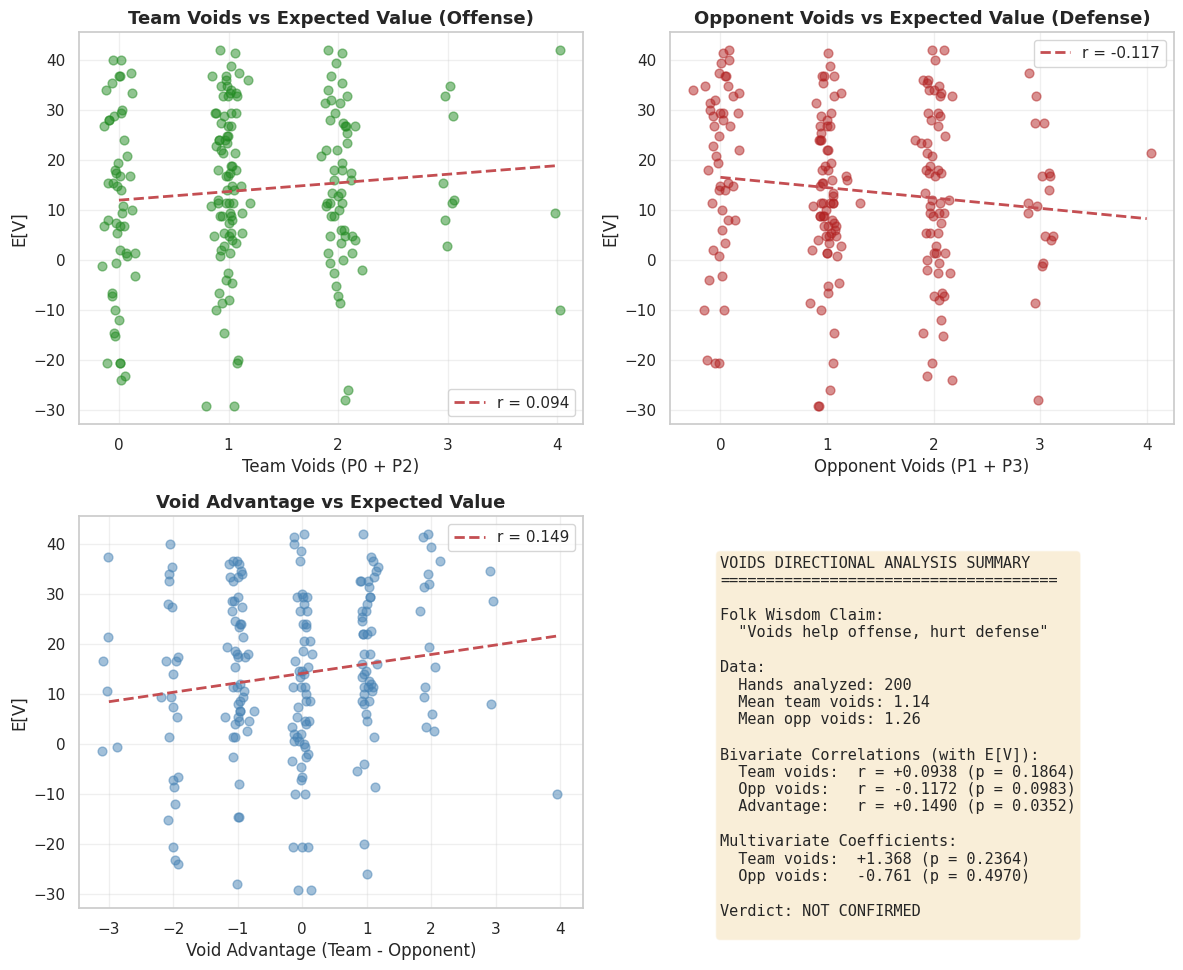

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Team voids vs E[V]
ax = axes[0, 0]
ax.scatter(df['team_voids'] + np.random.normal(0, 0.08, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='forestgreen')

z = np.polyfit(df['team_voids'], df['V_mean'], 1)
p_line = np.poly1d(z)
x_line = np.array([df['team_voids'].min(), df['team_voids'].max()])
ax.plot(x_line, p_line(x_line), 'r--', linewidth=2, label=f'r = {r_team:.3f}')

ax.set_xlabel('Team Voids (P0 + P2)', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Team Voids vs Expected Value (Offense)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Opponent voids vs E[V]
ax = axes[0, 1]
ax.scatter(df['opp_voids'] + np.random.normal(0, 0.08, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='firebrick')

z2 = np.polyfit(df['opp_voids'], df['V_mean'], 1)
p_line2 = np.poly1d(z2)
x_line2 = np.array([df['opp_voids'].min(), df['opp_voids'].max()])
ax.plot(x_line2, p_line2(x_line2), 'r--', linewidth=2, label=f'r = {r_opp:.3f}')

ax.set_xlabel('Opponent Voids (P1 + P3)', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Opponent Voids vs Expected Value (Defense)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Void advantage vs E[V]
ax = axes[1, 0]
ax.scatter(df['void_advantage'] + np.random.normal(0, 0.08, len(df)), df['V_mean'], 
           alpha=0.5, s=40, color='steelblue')

z3 = np.polyfit(df['void_advantage'], df['V_mean'], 1)
p_line3 = np.poly1d(z3)
x_line3 = np.array([df['void_advantage'].min(), df['void_advantage'].max()])
ax.plot(x_line3, p_line3(x_line3), 'r--', linewidth=2, label=f'r = {r_adv:.3f}')

ax.set_xlabel('Void Advantage (Team - Opponent)', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Void Advantage vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

if directional_confirmed:
    verdict = "CONFIRMED"
elif team_confirmed or opp_confirmed:
    verdict = "PARTIAL"
else:
    verdict = "NOT CONFIRMED"

summary_text = f"""VOIDS DIRECTIONAL ANALYSIS SUMMARY
=====================================

Folk Wisdom Claim:
  "Voids help offense, hurt defense"

Data:
  Hands analyzed: {len(df)}
  Mean team voids: {df['team_voids'].mean():.2f}
  Mean opp voids: {df['opp_voids'].mean():.2f}

Bivariate Correlations (with E[V]):
  Team voids:  r = {r_team:+.4f} (p = {p_team:.4f})
  Opp voids:   r = {r_opp:+.4f} (p = {p_opp:.4f})
  Advantage:   r = {r_adv:+.4f} (p = {p_adv:.4f})

Multivariate Coefficients:
  Team voids:  {coef_team:+.3f} (p = {pval_team:.4f})
  Opp voids:   {coef_opp:+.3f} (p = {pval_opp:.4f})

Verdict: {verdict}
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/26e_voids_directional.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Create results DataFrame
results = {
    'metric': ['n_hands', 'mean_team_voids', 'mean_opp_voids',
               'r_team_ev', 'p_team_ev',
               'r_opp_ev', 'p_opp_ev',
               'r_advantage_ev', 'p_advantage_ev',
               'coef_team', 'ci_team_low', 'ci_team_high', 'p_team_multivar',
               'coef_opp', 'ci_opp_low', 'ci_opp_high', 'p_opp_multivar',
               'team_confirmed', 'opp_confirmed', 'directional_confirmed'],
    'value': [len(df), df['team_voids'].mean(), df['opp_voids'].mean(),
              r_team, p_team,
              r_opp, p_opp,
              r_adv, p_adv,
              coef_team, ci_team[0], ci_team[1], pval_team,
              coef_opp, ci_opp[0], ci_opp[1], pval_opp,
              1 if team_confirmed else 0, 1 if opp_confirmed else 0, 
              1 if directional_confirmed else 0]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26e_voids_directional.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26e_voids_directional.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Voids Are Directional")
print("="*60)

print(f"\n1. CLAIM TESTED:")
print("   'Voids help offense, hurt defense'")

print(f"\n2. DATA:")
print(f"   Hands analyzed: {len(df)}")
print(f"   Mean team voids: {df['team_voids'].mean():.2f}")
print(f"   Mean opponent voids: {df['opp_voids'].mean():.2f}")

print(f"\n3. RESULTS:")
print(f"   Bivariate r(team_voids, E[V]): {r_team:+.4f} (p = {p_team:.4f})")
print(f"   Bivariate r(opp_voids, E[V]):  {r_opp:+.4f} (p = {p_opp:.4f})")
print(f"   Multivariate team coef: {coef_team:+.3f} (p = {pval_team:.4f})")
print(f"   Multivariate opp coef:  {coef_opp:+.3f} (p = {pval_opp:.4f})")

print(f"\n4. VERDICT:")
if directional_confirmed:
    print("   ✓ CONFIRMED: Voids are directional")
    print(f"   Each team void adds ~{coef_team:.1f} to E[V]")
    print(f"   Each opponent void subtracts ~{abs(coef_opp):.1f} from E[V]")
elif team_confirmed:
    print("   ~ PARTIAL: Team voids help, but opponent voids effect not significant")
elif opp_confirmed:
    print("   ~ PARTIAL: Opponent voids hurt, but team voids effect not significant")
else:
    print("   ✗ NOT CONFIRMED: Voids don't show clear directional effect")


KEY INSIGHTS: Voids Are Directional

1. CLAIM TESTED:
   'Voids help offense, hurt defense'

2. DATA:
   Hands analyzed: 200
   Mean team voids: 1.14
   Mean opponent voids: 1.26

3. RESULTS:
   Bivariate r(team_voids, E[V]): +0.0938 (p = 0.1864)
   Bivariate r(opp_voids, E[V]):  -0.1172 (p = 0.0983)
   Multivariate team coef: +1.368 (p = 0.2364)
   Multivariate opp coef:  -0.761 (p = 0.4970)

4. VERDICT:
   ✗ NOT CONFIRMED: Voids don't show clear directional effect


## Summary

### Folk Wisdom: "Voids help offense, hurt defense"

**Result**: [Populated by notebook execution]

### Interpretation

We test directionality by comparing:
- **Team voids** (P0 + P2, the declaring team) - should help E[V]
- **Opponent voids** (P1 + P3, defenders) - should hurt E[V] (from declarer's perspective)

If voids are truly directional, we expect:
1. Positive coefficient for team_voids (helps offense)
2. Negative coefficient for opp_voids (hurts defense, i.e., helps opponents)

### Output Files

- `results/tables/26e_voids_directional.csv` - Summary statistics
- `results/figures/26e_voids_directional.png` - 4-panel visualization